### Decision tree classifier

The theory for building a decision tree for classification tasks. This algorithm can later be used to create a random forest model. The image below shows some basic terminology and a sketch of a decision tree.

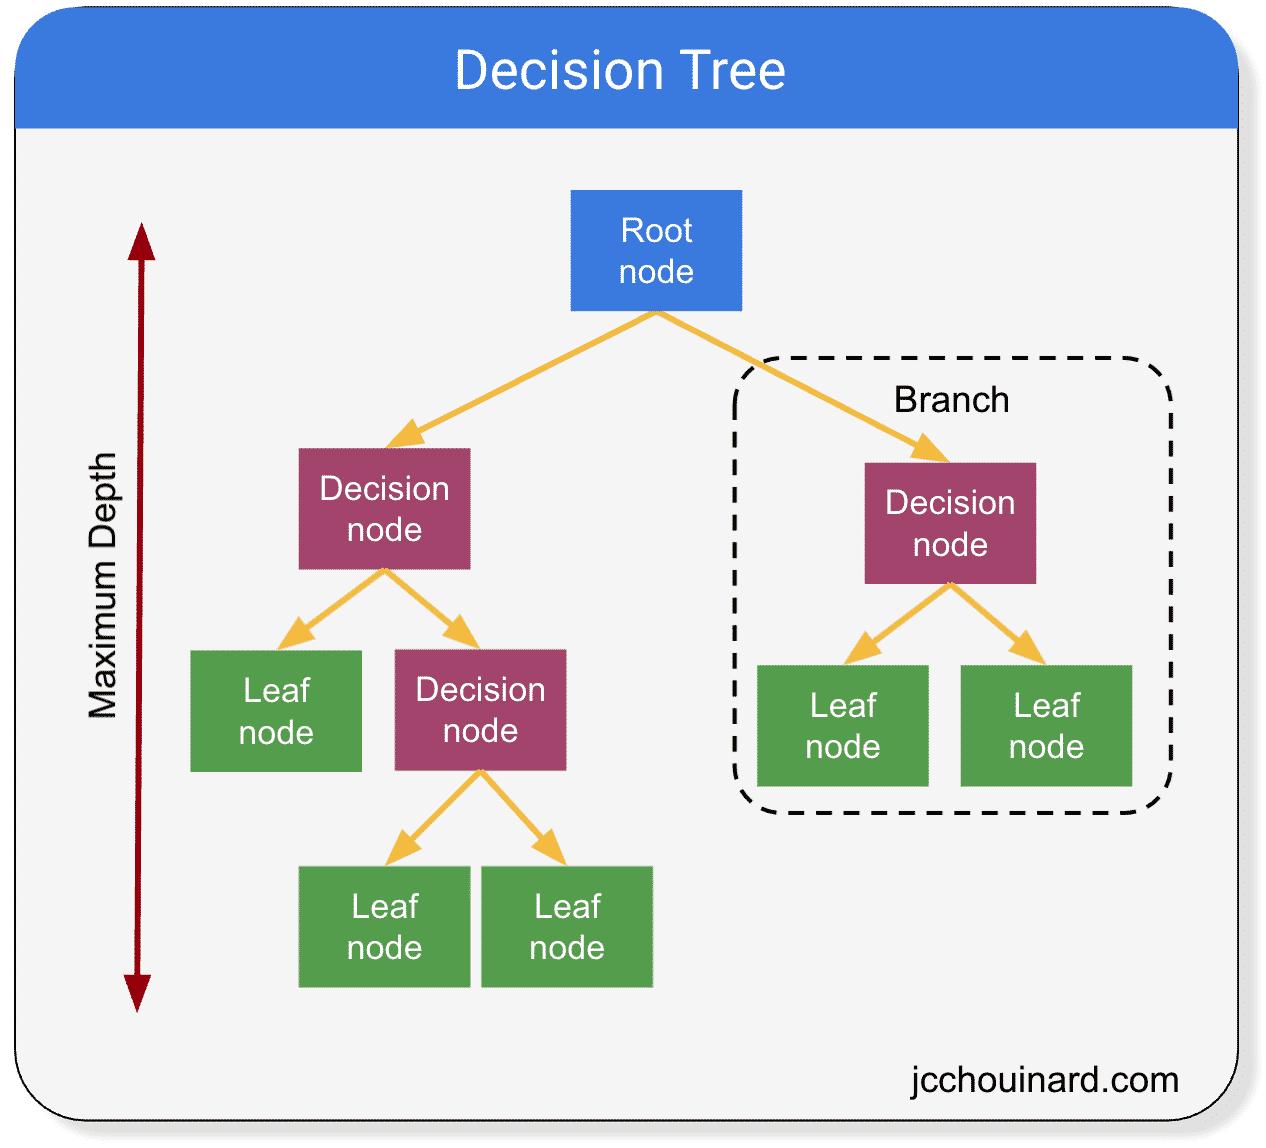

Image from: https://www.jcchouinard.com/decision-trees-in-machine-learning/

In [1]:
import numpy as np
import pandas as pd

The idea of the decision tree is that we split the data at each step, and perform a number of these steps. The splitting is based on the features that we train on. For instance, feature A may be True or False, so that we split based on whether the entry we look at is True or False. Or feature B may be continuous, in which case we select a useful value within its range and split based on whether the entry has a value larger or smaller than that selected value.

Now to determine which feature we start with, and which comes after that and so on, we use a splitting criterion. In this case we use the Gini impurity (which should be easiest to start with). Before explaining what this metric is, the idea for the tree is that we try out each feature to start with and test which gives us the best score on the metric. This feature is then chosen to be first. Then we follow one of the splits and repeat this with the remaining features.

Let's then look at the Gini impurity metric. In the best case scenario, it is 0, meaning the data is 'pure'. In one sentence, it measures the probability that you misclassify an entry in the data if you randomly assign it one of the target labels, based on the distribution of those labels in the target data. In more detail: say we have labels A and B, and 30% of the target data has label A and 70% label B (this is the distribution of labels). The relative frequencies are then defined as $p_A = 0.3$ and $p_B = 0.7$; generally $p_i = N_i/N_\mathrm{total}$. So the chance you choose an entry with label A is 0.3, and the probability you mislabel it is 1-0.3=0.7. Generally, with more than 2 labels, the probability for choosing label $i$ is $p_i$ such that the probability for mislabeling is $\sum_{k \neq i} p_k = 1 - p_i$ (since $\sum_{k \neq i} p_k + p_i = \sum_i p_i = 1$). Thus the combined chance of choosing entry $i$ and misclassifying it is $p_i (1-p_i)$, and we obtain the Gini impurity by summing this for all entries:

\begin{equation}
    \mathrm{Gini} = \sum_i p_i \cdot (1 - p_i) = 1 - \sum_i p_i^2.
\end{equation}

In [2]:
def gini_impurity(y):
    """
    Calculate the Gini impurity for a set of labels.
    
    Parameters:
    y (array-like): Array of labels.
    
    Returns:
    float: Gini impurity value.
    """
    if len(y) == 0:
        return 0.0
    
    # Count occurrences of each label
    counts = pd.Series(y).value_counts(normalize=True)
    
    # Calculate Gini impurity
    gini = 1 - np.sum(counts ** 2)
    
    return gini

For the decision tree, we implement this as follows. First a feature is chosen and we split the dataset based on that. For both of these datasets, we then calculate the Gini impurity, using how often each target label appears in the split data and the total number of entries in each set. These two Gini impurities are then combined using a weighted sum, with the weight determined by the amount of data in each split set:

\begin{equation}
    \mathrm{Gini_{weighted}} = \frac{N_\mathrm{left}}{N_\mathrm{total}} \mathrm{Gini_{left}} + \frac{N_\mathrm{right}}{N_\mathrm{total}} \mathrm{Gini_{right}},
\end{equation}

where $N_\mathrm{total}$ is the number of entries before the split.

Here it becomes clear why this Gini impurity will improve the decision tree: we select splits in such a way that we get as many of the same target labels in the same split. So, in the perfect case, we end up with just a single label after a split. If an entry in the test data that we want to predict then ends up in that same leaf node, we can classify it as that label. In reality we likely won't find splits that perfectly separate the target labels, so that we end up misclassifying some test entries; but we have minimized tha chances of this happening.

In [3]:
def gini_weighted(y_left, y_right):
    """
    Calculate the weighted Gini impurity after a split.
    
    Parameters:
    y_left (array-like): Array of labels for the left dataset.
    y_right (array-like): Array of labels for the right dataset.
    
    Returns:
    float: Weighted Gini impurity value.
    """
    N_left = len(y_left)
    N_right = len(y_right)
    N_total = N_left + N_right

    gini_left = gini_impurity(y_left)
    gini_right = gini_impurity(y_right)
    
    gini_weighted = (N_left / N_total) * gini_left + (N_right / N_total) * gini_right
    return gini_weighted

This can now be applied to making the decision tree. Let's look more closely at the creation of the splits. For boolean features this is simple, as we just have one split for True and one for False. For continuous features we need to find a value to split between. In theory one could use every value that lies between the given datapoints; for instance for the array [1, 3, 7, 8] you could pick the values 2, 5, and 7.5 to split between. However, as the number of datapoints increases, so does the number of possible splits, so that this method becomes very computationally expensive for large amounts of data. So instead, we will just look at three split values here, for the first quantile, median, and third quantile. Thus in a sense we create three possible feature splits out of each continuous feature.

Additionally, once a split on a boolean feature is done, it is no longer possible to split on it again. For continuous features this is still possible though; it might be helpful to split on the same feature again at a different value. Therefore we will constantly consider a split on a continuous feature, even if it has been done before. Eventually these splits should not be helpful anymore and are no longer done.

Finally, we may also have to deal with an ordinal categorical variable, values like [0, 1, 2, 3, 4]. In this case we can also use the quantiles method, but this is not helpful of we only have three rankings. (And in case the continuous value only has three numbers left the same applies.) So for those cases we will only look at the median as a split.

In [4]:
def determine_continuous_split(X_feature):
    """
    Determine the split points for a continuous feature, being the first quantile, median, and third quantile.
    If there are 3 or less unique values, this is not useful, so return the median instead.

    Parameters:
    X_feature (array-like): Array of feature values.

    Returns:
    (list or float): List of split points [first quantile, median, third quantile], median if not enough data to determine quantiles.
    """
    if len(X_feature.unique()) <= 3:
        median = np.median(X_feature)
        return median  # Not enough data to determine quantiles
    else:
        first_quantile = np.quantile(X_feature, 0.25)
        median = np.median(X_feature)
        third_quantile = np.quantile(X_feature, 0.75)
        return [first_quantile, median, third_quantile]

def split_node_and_find_best_split(X_feature, y):
    """
    Split a node based on the feature values in X_feature while determining the best split point 
    based on Gini impurity for continuous features.
    
    Parameters:
    X (array-like): Array of feature values.
    y (array-like): Labels.
    
    Returns:
    array-like: Two arrays representing the left and right splits for and y.
    (float or None): The best split value for continuous features, None for boolean features.
    """
    # First figure out if the feature is continuous or boolean
    if set(X_feature.unique()).issubset({0, 1}):  # works for both 0/1 and True/False as values
        # Boolean feature
        #X_left = X_feature[X_feature == 0]
        #X_right = X_feature[X_feature == 1]
        y_left = y[X_feature.index[X_feature == 0]]
        y_right = y[X_feature.index[X_feature == 1]]
        best_split_value = None  # No split value for boolean features
    else:
        # Continuous feature
        split_points = determine_continuous_split(X_feature)

        # If split points are a single value (median), treat it as a binary split
        if isinstance(split_points, float):
            median = split_points
            #X_left = X_feature[X_feature <= median]
            #X_right = X_feature[X_feature > median]
            y_left = y[X_feature.index[X_feature <= median]]
            y_right = y[X_feature.index[X_feature > median]]
            best_split_value = median  # Need to return this
        else:
            # Figure out which split is best, using the lowest Gini impurity
            best_gini = float('inf')
            for split_value in split_points:
                #X_left = X_feature[X_feature <= split_value]
                #X_right = X_feature[X_feature > split_value]
                y_left = y[X_feature.index[X_feature <= split_value]]
                y_right = y[X_feature.index[X_feature > split_value]]
                gini = gini_weighted(y_left, y_right)
                if gini < best_gini:
                    best_gini = gini
                    best_split_value = split_value
            # Now split based on the best split value found
            #X_left = X_feature[X_feature <= best_split_value]
            #X_right = X_feature[X_feature > best_split_value]
            y_left = y[X_feature.index[X_feature <= best_split_value]]
            y_right = y[X_feature.index[X_feature > best_split_value]]
    
    return y_left, y_right, best_split_value

# Then apply the function to each function and determine the best split
def determine_best_split(X, y):
    """
    Determine the best split for a dataset based on Gini impurity.
    
    Parameters:
    X (DataFrame): Feature dataframe.
    y (array-like): Labels.
    
    Returns:
    tuple: The best feature and the best split value (None for boolean features).
    """
    best_gini = float('inf')

    for column in X.columns:
        X_feature = X[column]
        y_left, y_right, best_split_value = split_node_and_find_best_split(X_feature, y)
        
        # Calculate Gini impurity for the split
        gini = gini_weighted(y_left, y_right)
        if gini < best_gini:
            best_gini = gini
            best_split_feature = (column, best_split_value)  # split_value is None for boolean features
    return best_split_feature

In [5]:
# Test if it splits right
test_data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8],
    'feature2': [True, False, True, False, True, False, True, False], # [0, 1, 0, 1, 0, 1, 0, 1],
    'label': [1, 1, 1, 1, 0, 0, 0, 0] # for feature1 better
    })
X = test_data[['feature1', 'feature2']]
y = test_data['label']
best_split_feature = determine_best_split(X, y)
print("Best split feature:", best_split_feature)

Best split feature: ('feature1', 4.5)


The creation of new splits will continue until one of two things happens: either we reach the maximum depth that has been set for this model, or the Gini impurity does not get better, in the sense that the difference of the impurity between the data before the split and after is smaller than some threshold value. We will set the default of this value to 0, so that there is always at least some increase, but a larger value could also be set to prevent overfitting. (Note that we do not allow for the increase to be equal to the threshold, it needs to be larger. This prevents that we keep adding splits resulting in one empty leaf and one node that is the same as its parent, which is not helpful.)

In [6]:
def check_impurity_decrease_threshold(y, y_left, y_right, threshold):
    """
    Calculate the impurity decrease from a split and if it meets a threshold.
    
    Parameters:
    y (array-like): Array of labels before the split.
    y_left (array-like): Array of labels for the left dataset after the split.
    y_right (array-like): Array of labels for the right dataset after the split.
    threshold (float): The threshold to compare against.
    
    Returns:
    bool: True if the impurity decrease is greater than the threshold, False otherwise.
    """
    gini_before = gini_impurity(y)
    gini_after = gini_weighted(y_left, y_right)
    
    return (gini_before - gini_after) > threshold

Now to actually save the structure of the tree, we will use a big dictionary. An example is this:

```python
tree = {
    'feature': 'feature1',
    'split': 0.5,
    'is_leaf': False,
    'left': {
        'feature': 'feature2',
        'split': None,
        'is_leaf': False,
        'left': {
            'class': 'Class A',
            'is_leaf': True
        },
        'right': {
            'class': 'Class B',
            'is_leaf': True
        }
    },
    'right': {
        'feature': 'feature3',
        'split': 2.5,
        'is_leaf': False,
        'left': {
            'class': 'Class C',
            'is_leaf': True
        },
        'right': {
            'class': 'Class D',
            'is_leaf': True
        }
    }
}
```

As we can see, every part of the tree has the `is_leaf` parameter, showing whether we are in a node or in a leaf at the end of the tree. The leaf then also contains the `class` parameter, indicating the class label that we predict an entry ending up in that leaf to have. The nodes have a `feature` and `split` parameter, indicating the feature that is split on and the split value in the case of a continuous feature. Finally each node has the `left` and `right` parameter, which links the different nodes in the tree together.

In [15]:
def split_node_given_best_split(X, y, feature, best_split_value):
    """
    Split a node based on the feature values in X_feature given the predetermined best split point.
    
    Parameters:
    X (array-like): Array of feature values.
    y (array-like): Labels.
    best_split_value (float or None): The best split value for continuous features, None for boolean features.
    
    Returns:
    array-like: Four arrays representing the left and right splits for X and for y.
    """
    X_feature = X[feature]
    if best_split_value is None:
        # Boolean feature
        X_left = X[X_feature == 0]
        X_right = X[X_feature == 1]
        y_left = y[X.index[X_feature == 0]]
        y_right = y[X.index[X_feature == 1]]
    else:
        X_left = X[X_feature <= best_split_value]
        X_right = X[X_feature > best_split_value]
        y_left = y[X.index[X_feature <= best_split_value]]
        y_right = y[X.index[X_feature > best_split_value]]
    
    return X_left, X_right, y_left, y_right

def fit(X, y, max_depth=None, min_samples_split=2, min_samples_leaf=1, verbose=False, threshold=0.0, depth=0):
    """
    Build up the tree recursively by fitting the training data.
    This needs to start with depth at 0, which is passed as an argument to make the recursion work.

    Parameters:
    X (DataFrame): Feature dataframe.
    y (array-like): Labels.
    max_depth (int, optional): Maximum depth of the tree. Default is None (no limit).
    min_samples_split (int, optional): Minimum number of samples required to split an internal node. Default is 2.
    min_samples_leaf (int, optional): Minimum number of samples required to be at a leaf node. Default is 1.
    verbose (bool, optional): If True, print the reasons for stopping. Default is False.
    threshold (float): The threshold to compare against for increasing score, default=0.0.

    Returns:
    dict: A dictionary representing the decision tree.
    """
    # First check all stopping criteria
    if (max_depth is not None and depth >= max_depth):
        if verbose:
            print(f"Stopping at depth {depth} due to max_depth limit.")
        majority_class = y.mode()[0]
        return {'class': majority_class, 'is_leaf': True}
    elif len(y) < min_samples_split:
        if verbose:
            print(f"Stopping at depth {depth} due to min_samples_split limit.")
        majority_class = y.mode()[0]
        return {'class': majority_class, 'is_leaf': True}

    # For the Gini score increase and min_samples_leaf criteria, we need to do the split first
    column, split_value = determine_best_split(X, y)
    X_left, X_right, y_left, y_right = split_node_given_best_split(X, y, column, split_value)
    if len(y_left) < min_samples_leaf or len(y_right) < min_samples_leaf:
        if verbose:
            print(f"Stopping at depth {depth} due to min_samples_leaf limit.")
        majority_class = y.mode()[0]
        return {'class': majority_class, 'is_leaf': True}
    # Note that now the possibility exists that the best split resulted in too few samples in a leaf, 
    # but maybe another split would not do that, while still improving the Gini score. 
    # Taking that into account by checking if another split does not result in too few samples in a leaf
    # is very computationally expensive though (you would basically have to run split_node_and_find_best_split() 
    # again while saving the order of the Gini scores to find the second best, third best, etc. features), 
    # and the gain is likely very small, so we do not implement that here.
    
    better_score = check_impurity_decrease_threshold(y, y_left, y_right, threshold)
    if not better_score:
        if verbose:
            print(f"Stopping at depth {depth} as no better score is found.")
        majority_class = y.mode()[0]
        return {'class': majority_class, 'is_leaf': True}
    
    # If none of the criteria are met, we continue here
    # If it is a boolean feature we can just take it out, as splitting on it again is nonsense
    if split_value is None:
        X_left = X_left.drop(columns=[column])
        X_right = X_right.drop(columns=[column])

    # Recursively build the left and right subtrees, adding 1 to the depth
    left_subtree = fit(X_left, y_left, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, verbose=verbose, depth=depth + 1)
    right_subtree = fit(X_right, y_right, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, verbose=verbose, depth=depth + 1)

    # Return the current node with its left and right subtrees; in the end this contains the full tree
    return {
        'feature': column,
        'split': split_value,
        'is_leaf': False,
        'left': left_subtree,
        'right': right_subtree
    }


In [17]:
test_data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8],
    'feature2': [0, 1, 0, 1, 0, 1, 0, 1],
    'feature3': [1, 1, 1, 0, 1, 0, 0, 0],
    'label':    [0, 1, 1, 0, 1, 0, 1, 0]
    })
X = test_data[['feature1', 'feature2', 'feature3']]
y = test_data['label']
tree = fit(X, y, max_depth=3, min_samples_split=0, min_samples_leaf=0, verbose=True)
print("Decision Tree Structure:", tree)

Stopping at depth 2 as no better score is found.
Stopping at depth 2 as no better score is found.
Stopping at depth 2 as no better score is found.
Stopping at depth 2 as no better score is found.
Decision Tree Structure: {'feature': 'feature2', 'split': None, 'is_leaf': False, 'left': {'feature': 'feature1', 'split': 2.5, 'is_leaf': False, 'left': {'class': 0, 'is_leaf': True}, 'right': {'class': 1, 'is_leaf': True}}, 'right': {'feature': 'feature1', 'split': 3.5, 'is_leaf': False, 'left': {'class': 1, 'is_leaf': True}, 'right': {'class': 0, 'is_leaf': True}}}


Let's look at the resulting tree dictionary in detail:

```python
tree = {
    'feature': 'feature2', 
    'split': None, 
    'is_leaf': False, 
    'left': {
        'feature': 'feature1', 
        'split': 2.5, 
        'is_leaf': False, 
        'left': {
            'class': 0, 
            'is_leaf': True
        }, 
        'right': {
            'class': 1, 
            'is_leaf': True
        }
    }, 
    'right': {
        'feature': 'feature1', 
        'split': 3.5, 
        'is_leaf': False, 
        'left': {
            'class': 1, 
            'is_leaf': True
        }, 
        'right': {
            'class': 0, 
            'is_leaf': True
        }
    }
}
```

The root node splits on `feature2`, which is boolean. The both next nodes split on `feature1`, but the left has a split value of 2.5 while the right one has a split value of 3.5. At the next level are only leaves, and so `feature3` is never used. The fitting stops because no further score gain can be found.

Now we write the predict function that traverses the tree in order to predict what the value in test data should be.

In [18]:
def predict(tree, X):
    """
    Predict the class for each sample in X using the decision tree.
    
    Parameters:
    tree (dict): The decision tree structure.
    X (DataFrame): Feature dataframe for which to make predictions.
    
    Returns:
    array-like: Predicted classes for each sample in X.
    """
    predictions = []
    
    for _, row in X.iterrows():
        node = tree  # start at the root node
        while not node['is_leaf']:
            feature = node['feature']
            split_value = node['split']
            data_feature_value = row[feature]
            if split_value is None:  # Boolean feature
                if data_feature_value == 0:
                    # As we trained the model to go left for 0, go left here
                    node = node['left']
                else:
                    node = node['right']
            else:  # Continuous feature
                if data_feature_value <= split_value:
                    # As we trained the model to go left for <= split_value, go left here
                    node = node['left']
                else:
                    node = node['right']
            # After going down, if the node is still not a leaf, repeat this
        # When we reach a leaf node, append the predicted class to the predictions
        predictions.append(node['class'])
    
    return np.array(predictions)

In [19]:
print(test_data)
test_predictions = predict(tree, X)
print("Predictions:", test_predictions)
# See that in this test case all predicted labels are correct

   feature1  feature2  feature3  label
0         1         0         1      0
1         2         1         1      1
2         3         0         1      1
3         4         1         0      0
4         5         0         1      1
5         6         1         0      0
6         7         0         0      1
7         8         1         0      0
Predictions: [0 1 1 0 1 0 1 0]


To check how well the model works, we add a score function. The metric for this is the accuracy, so how many labels were classified correctly.

In [20]:
def score(y_true, y_pred):
    """
    Calculate the accuracy of predictions.
    
    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    
    Returns:
    float: Accuracy score.
    """
    return np.mean(y_true == y_pred)

accuracy = score(y, test_predictions)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [21]:
# Test on larger dataset
iris_data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv', header=None)
iris_data.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
# We predict the Iris labels based on the first four features
X = iris_data.drop(columns=[4])
y = iris_data[4]

# Map the labels to integers
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the decision tree and make predictions
tree = fit(X_train, y_train, max_depth=4, verbose=False)
predictions = predict(tree, X_test)
accuracy = score(y_test, predictions)
print("Iris Dataset Accuracy:", accuracy)
# Some playing around shows that for a max_depth of 4 or higher, the accuracy is 1.0
# For max_depth=1 it is 0.57, for max_depth=2 it is 0.9, and for max_depth=3 it is 0.93

# To test the min_samples_leaf parameter, we set it to a large value so it does something
tree = fit(X_train, y_train, max_depth=4, min_samples_leaf=10, verbose=False)
predictions = predict(tree, X_test)
accuracy = score(y_test, predictions)
print("Iris Dataset Accuracy with min_samples_leaf=10:", accuracy)

Iris Dataset Accuracy: 1.0
Iris Dataset Accuracy with min_samples_leaf=10: 0.9333333333333333


In [23]:
# Try sklearn's DecisionTreeClassifier for comparison
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)
sklearn_predictions = clf.predict(X_test)
sklearn_accuracy = score(y_test, sklearn_predictions)
print("Sklearn Decision Tree Classifier Accuracy:", sklearn_accuracy)
# This already gives perfect accuracy for max_depth=3, and is faster

Sklearn Decision Tree Classifier Accuracy: 1.0


In [28]:
# Different dataset
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()
X = pd.DataFrame(data=cancer_data.data, columns=cancer_data.feature_names)
y = pd.Series(cancer_data.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = fit(X_train, y_train, max_depth=3, verbose=False)
predictions = predict(tree, X_test)
accuracy = score(y_test, predictions)
print("Breast Cancer Dataset Accuracy:", accuracy)
# Here we actually see that the highest accuracy is for max_depth=3; above that it first decreases from overfitting, then it fluctuates

# Compare with sklearn's DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)
sklearn_predictions = clf.predict(X_test)
sklearn_accuracy = score(y_test, sklearn_predictions)
print("Sklearn Decision Tree Classifier Accuracy (Breast Cancer):", sklearn_accuracy)
# Interestingly, we get a slightly better score than sklearn at different depths, although sklearn is much faster

Breast Cancer Dataset Accuracy: 0.9824561403508771
Sklearn Decision Tree Classifier Accuracy (Breast Cancer): 0.9473684210526315


In [29]:
# DrivenData Flu Shot data, preprocessed
X_train = pd.read_csv('X_train_prep.csv')
y_train = pd.read_csv('y_train.csv')['h1n1_vaccine']
X_test = pd.read_csv('X_valid_prep.csv')
y_test = pd.read_csv('y_valid.csv')['h1n1_vaccine']

tree = fit(X_train, y_train, max_depth=4, verbose=False)
predictions = predict(tree, X_test)
accuracy = score(y_test, predictions)
print("This Decision Tree on Custom Dataset Accuracy:", accuracy)

# Compare with sklearn's DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)
sklearn_predictions = clf.predict(X_test)
sklearn_accuracy = score(y_test, sklearn_predictions)
print("Sklearn Decision Tree Classifier Accuracy (Custom Dataset):", sklearn_accuracy)
# Here sklearn is better by only 0.03, and also faster

This Decision Tree on Custom Dataset Accuracy: 0.8406963684013478
Sklearn Decision Tree Classifier Accuracy (Custom Dataset): 0.8438786971171846


In the test cases it is clear that our implementation generates good results, that are similar to the model from sklearn. The only downside is that it is slower than sklearn, so for very large datasets it might not be able to get results in a reasonable amount of time.